In [12]:
import os
import re
import numpy as np
import pandas as pd
import tqdm
import scipy
import random
from cycler import cycler
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

import torch
from torch import nn
from torch.utils.data import DataLoader

import optuna
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search.basic_variant import BasicVariantGenerator

import snntorch as snn
from snntorch import surrogate, utils, functional as SF

import utils_fn
import network
from params import *
from train_eval import *

torch.manual_seed(22)

%reload_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({
    'axes.labelsize': 30.0,
    'grid.alpha': 0.6,
    'legend.framealpha': 0.6,
    "text.usetex": True,
    "font.family": "serif",
    'figure.figsize': [12,6],
    "font.size": 30,
    "hatch.linewidth": 0.0,
    "hatch.color": (0,0,0,0.0),
    "axes.prop_cycle": cycler(color=sns.color_palette("tab10"))
    })

#### Load train/valid/test set and create Data Loader

In [3]:
N_WIN = 232
N_RANGE_BINS = 10
WIN_LEN = 64
INP_SHAPE = [2, 232, 10, 64]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

train_dataset = torch.load('data/train_dataset_split_subj.pt')#, map_location=torch.device(device)
val_dataset = torch.load('data/val_dataset_split_subj.pt')#, map_location=torch.device(device))
test_dataset = torch.load('data/test_dataset_split_subj.pt')#, map_location=torch.device(device))

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader =  DataLoader(val_dataset, batch_size=batch)
test_loader = DataLoader(test_dataset, batch_size=1)

x = next(iter(train_loader))[0]

print(f"\nShape of each element in the dataloader: {x.shape}")
print(f"Number of elements in train - valid - test set: {len(train_dataset)} - {len(val_dataset)} - {len(test_dataset)}")

Using cuda device

Shape of each element in the dataloader: torch.Size([8, 2, 232, 10, 64])
Number of elements in train - valid - test set: 1680 - 138 - 182


The CIR has shape ($2$, $W$, $R$, $K$), where:

- $2$ is the number of convolutional channels (one for the real part of the CIR, one for the imaginary part);
- $W$ is the number of windows, in this case: $W=232$;
- $R$ is the number of range bins, in this case: $R=10$;
- $K$ is the length of each windows, in this case: $K=64$.

#### Plot some examples

In [4]:
ACTIVITIES = ["WALKING", "RUNNING", "SITTING", "HANDS"]
class_enc = {a:[i] for i, a in enumerate(ACTIVITIES)}
class_dec = {int(v[0]): k for k, v in class_enc.items()}
class_dec

{0: 'WALKING', 1: 'RUNNING', 2: 'SITTING', 3: 'HANDS'}

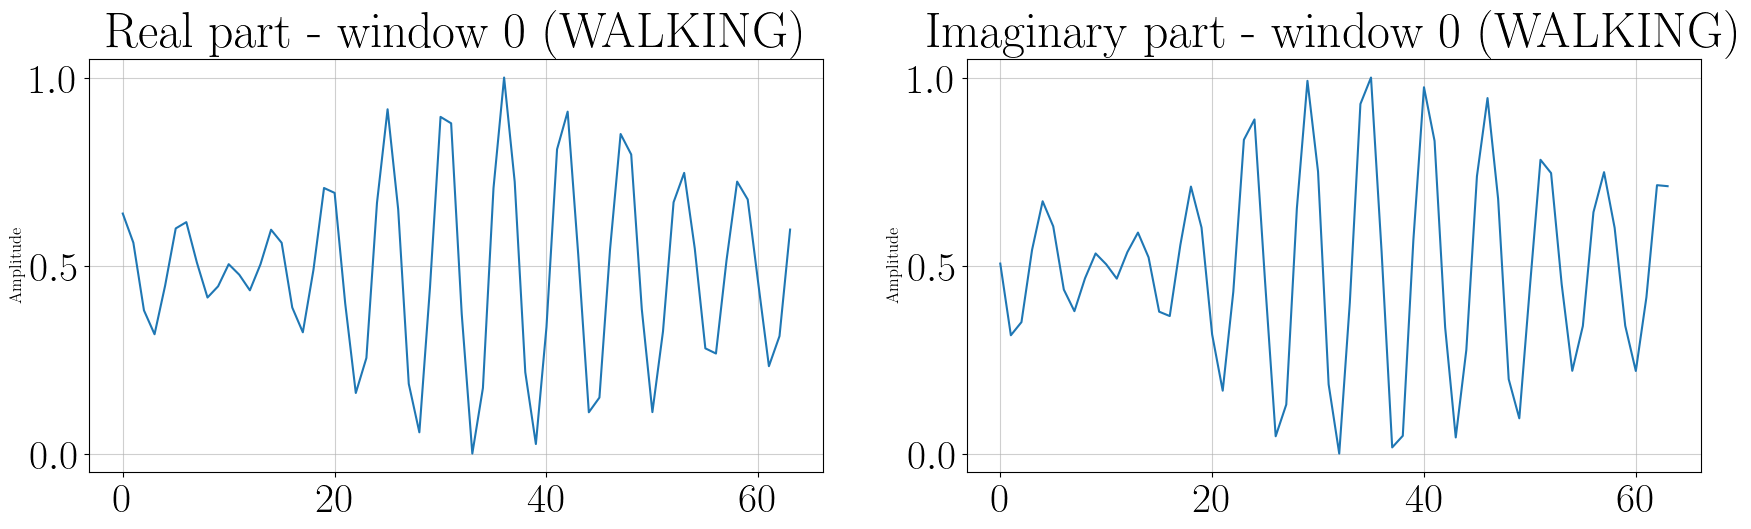

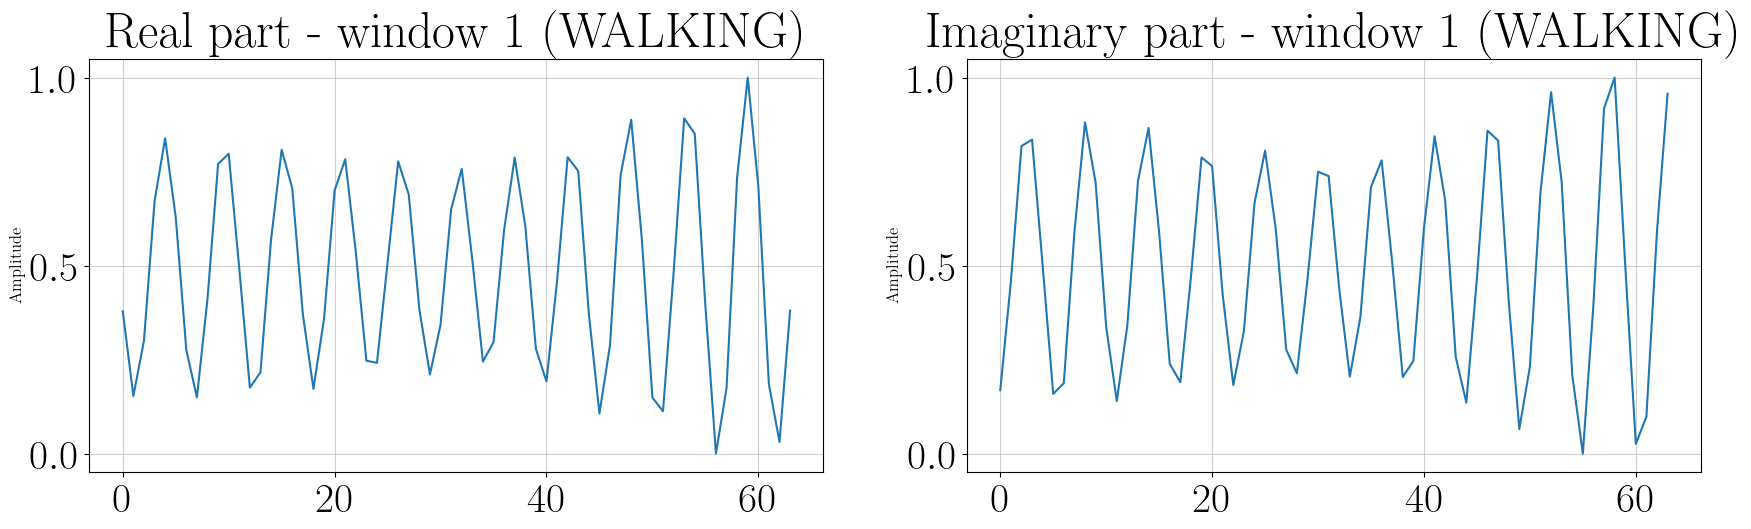

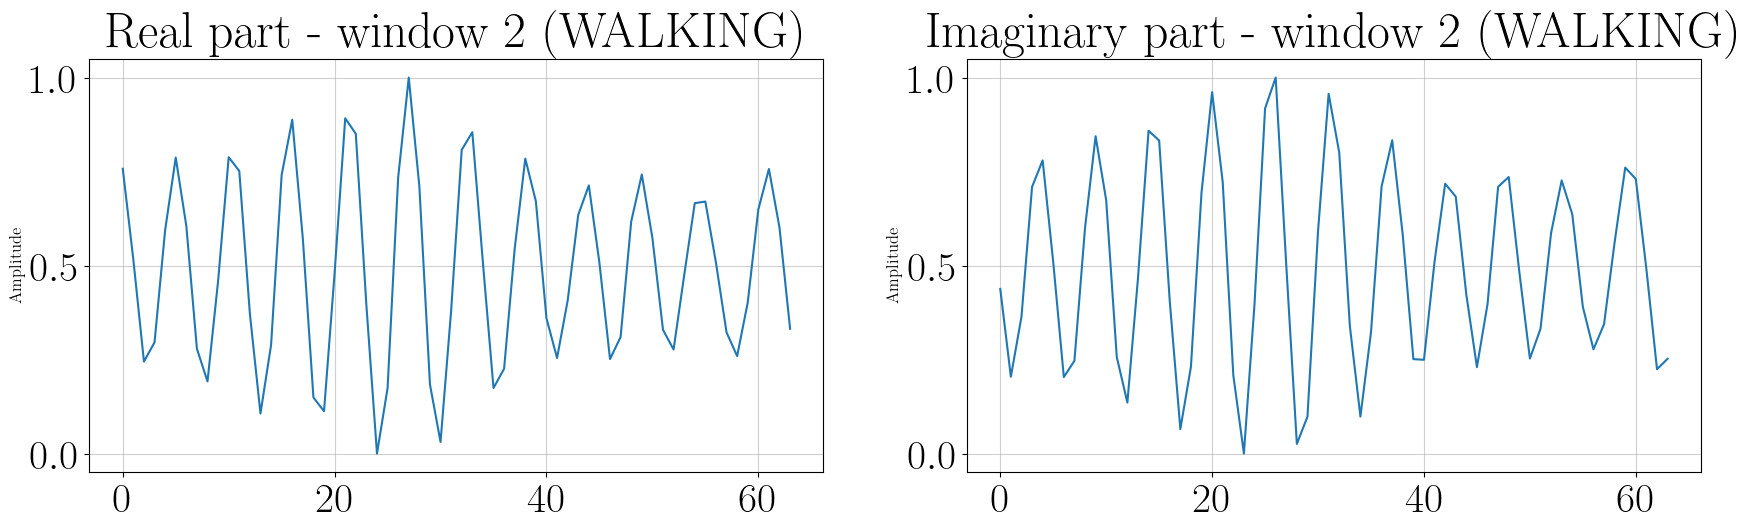

In [35]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0],train_dataset[i][-1]

for w in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(18,6))

    plt.subplot(121)
    plt.plot(X[0, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(f"Real part - window {w} ({class_dec[int(Y)]})")
    plt.grid()

    plt.subplot(122)
    plt.plot(X[1, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude',  fontsize=12)
    plt.title(f"Imaginary part - window {w} ({class_dec[int(Y)]})")
    plt.grid()
    plt.tight_layout()

    #plt.savefig('Signal_example1.png')
    plt.show()

### Models definition

In [4]:
class SCAE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(SCAE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.snn(encoded)  
        n_spikes = encoded.abs().mean()
        return n_spikes, decoded, clss
    
class LSE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(LSE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.snn(encoded)  
        n_spikes = encoded.abs().mean()
        return n_spikes, decoded, clss

#### Optimize $\tau$ parameter of the CAE

Values in $[0.1, 0.9]$ with a step size of 0.1. For each value of $\tau$ we made 5 different runs, to compute average and std of sparsity of the encoding and accuracy of classification in the validation set.

In [17]:
tau_values = np.arange(0.6, 1.0, 0.1)

csv_path = "Tau_vs_accuracy_sparsity.csv"

try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    df = pd.DataFrame(columns=["Tau", 
                               "Sparsity_avg", "Sparsity_std", 
                               "Accuracy_avg", "Accuracy_std"])
    
for tau in tau_values:
    print("###############")
    print(f"# Tau = {tau:.1f}")
    print("###############")

    sparsity_ls, accuracy_ls = [], []

    # repeat 5 runs with different initialization
    for run in range(5):
        print(f"  >> Run {run+1}/5")
        torch.cuda.empty_cache()

        autoencoder = network.cae_2(tau = tau,
                                    channels = 64, 
                                    kernel_size = (1,1,3), 
                                    stride = 1
                                    )

        snn = network.snn_1(input_shape = INP_SHAPE, 
                            hidden = [64,128], 
                            timesteps = 29,
                            kernel = (1,1,4),
                            stride = (1,2,2),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = surrogate.atan()
                            )

        net = LSE(autoencoder, snn).to(device) 
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

        trainer = Trainer(
            model = net,
            optimizer = optimizer,
            device = device,
            alpha = 0.95,
            Lambda = 0.0,
            acc_steps = 1,
            patience = 15,
            model_path = None
        )

        trainer.fit(
            train_loader = train_loader,
            val_loader = val_loader,
            epochs = 50
        )

        _, accuracy, sparsity = trainer.evaluate(val_loader)

        sparsity_ls.append(sparsity)
        accuracy_ls.append(accuracy)

    # log results
    new_row = pd.DataFrame([{
        "Tau": tau, 
        "Sparsity_avg": np.mean(sparsity_ls), 
        "Sparsity_std": np.std(sparsity_ls),
        "Accuracy_avg": np.mean(accuracy_ls),
        "Accuracy_std": np.std(accuracy_ls)
    }])

    df = pd.concat([df, new_row], ignore_index=True)
    df.to_csv(csv_path, index=False)    

###############
# Tau = 0.6
###############
  >> Run 1/5
Epoch 1 - train_loss: 0.6187 | train_acc: 0.7762 | val_loss: 0.4536 | val_acc: 0.7778
Epoch 6 - train_loss: 0.1009 | train_acc: 0.9792 | val_loss: 0.4285 | val_acc: 0.8681
Epoch 11 - train_loss: 0.0489 | train_acc: 0.9935 | val_loss: 0.7858 | val_acc: 0.8542
Epoch 16 - train_loss: 0.0452 | train_acc: 0.9929 | val_loss: 0.5677 | val_acc: 0.8819
Epoch 21 - train_loss: 0.0303 | train_acc: 0.9976 | val_loss: 0.4990 | val_acc: 0.9236
Epoch 26 - train_loss: 0.0382 | train_acc: 0.9940 | val_loss: 0.7501 | val_acc: 0.8681
Epoch 31 - train_loss: 0.0393 | train_acc: 0.9964 | val_loss: 0.7722 | val_acc: 0.8889
Early stopping at epoch 35
  >> Run 2/5
Epoch 1 - train_loss: 0.5791 | train_acc: 0.7738 | val_loss: 0.3665 | val_acc: 0.8403
Epoch 6 - train_loss: 0.1036 | train_acc: 0.9780 | val_loss: 0.5743 | val_acc: 0.7917
Epoch 11 - train_loss: 0.0768 | train_acc: 0.9833 | val_loss: 0.4379 | val_acc: 0.8681
Epoch 16 - train_loss: 0.0411 | train

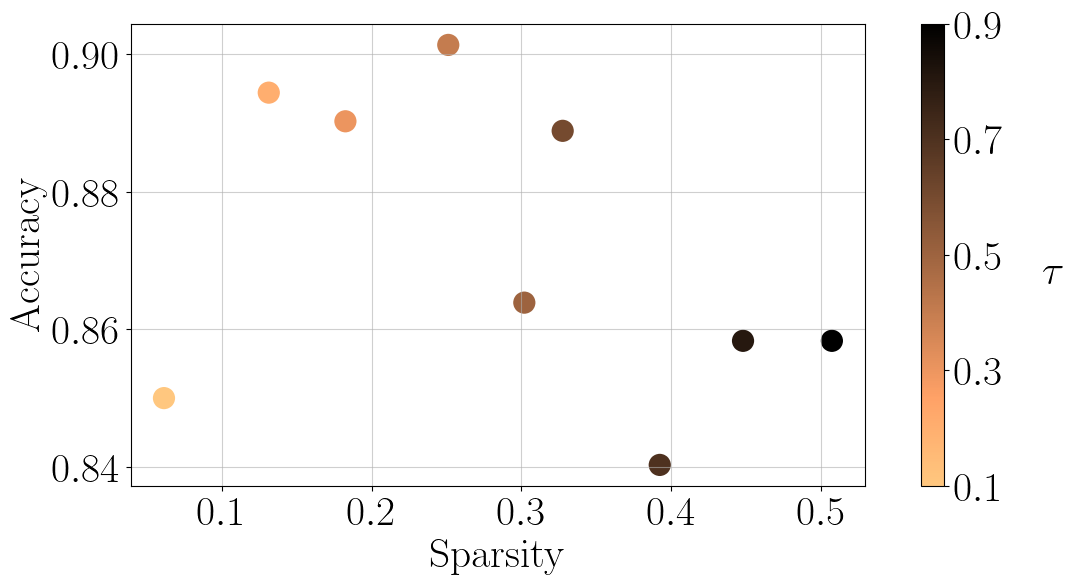

In [ ]:
metrics = pd.read_csv('Tau_vs_accuracy_sparsity.csv')

tau = metrics.Tau.values
sparsity = metrics.Sparsity_avg	.values
avg_acc = metrics.Accuracy_avg.values

plt.figure()
plt.scatter(sparsity, avg_acc, cmap=plt.colormaps.get_cmap('copper_r'),
            c=tau, linewidths=10)
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.grid()
colorbar = plt.colorbar(pad=0.06)#, location='top', orientation='horizontal')
colorbar.set_label(r'$\tau$', labelpad=35, rotation=0)
colorbar.set_ticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.savefig("Plots/sparsity_vs_acc_tau.png", bbox_inches='tight')
plt.show()

### Train with optimized hyperparams

In [30]:
torch.cuda.empty_cache()
autoencoder = network.cae_2(
                        tau = 0.4, 
                        channels = 64, 
                        kernel_size = (1,1,3), 
                        stride = 1, 
                        )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                Lambda = 0.0,
                acc_steps = 1,
                patience = 15,
                model_path = "./models/cae_2_snn_1.pt" 
        )

trainer.fit(
                train_loader = train_loader,
                val_loader = val_loader,
                epochs = 50
        )


Epoch 1 - train_loss: 0.6431 | train_acc: 0.7792 | val_loss: 0.4830 | val_acc: 0.8472
Epoch 6 - train_loss: 0.2021 | train_acc: 0.9494 | val_loss: 0.4067 | val_acc: 0.8889
Epoch 11 - train_loss: 0.1215 | train_acc: 0.9810 | val_loss: 0.4351 | val_acc: 0.8750
Epoch 16 - train_loss: 0.1027 | train_acc: 0.9863 | val_loss: 0.5364 | val_acc: 0.8750
Early stopping at epoch 17


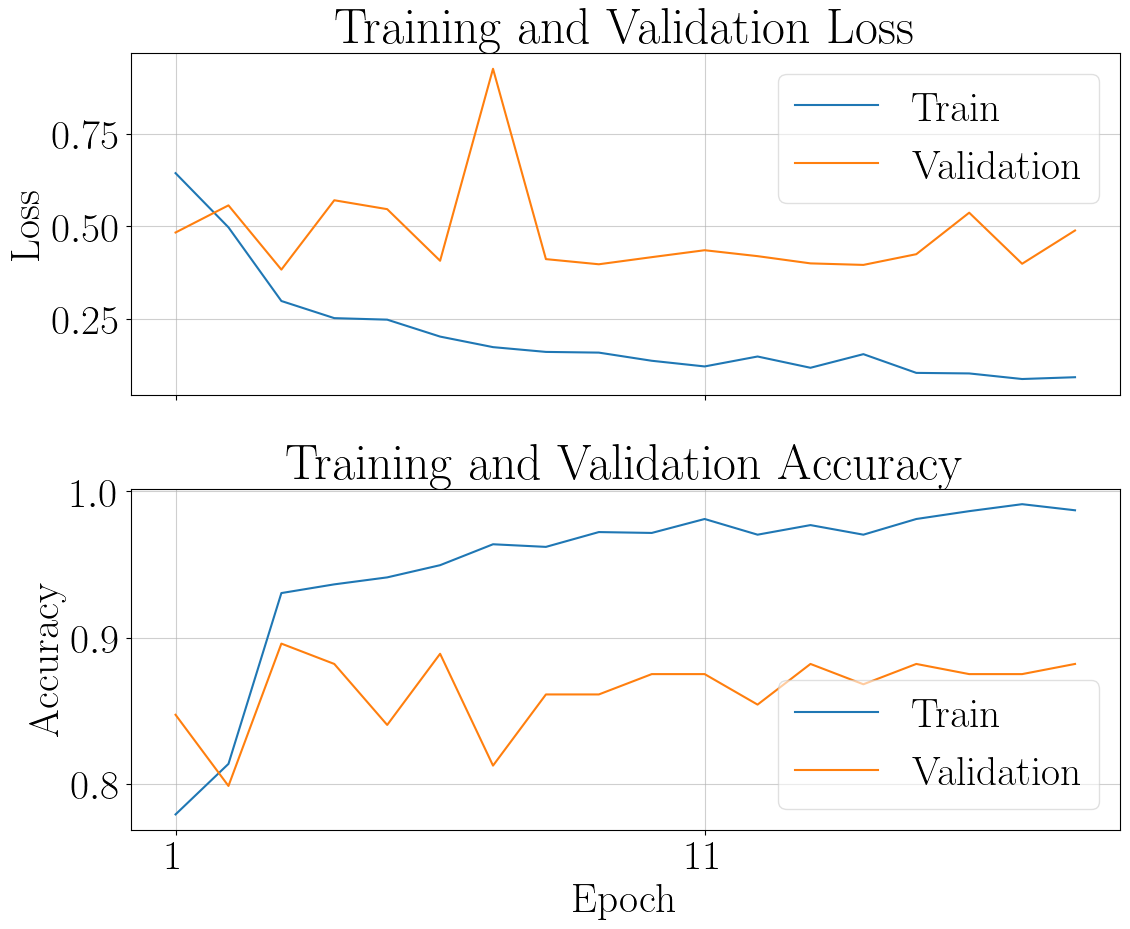

In [31]:
utils_fn.plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

### Results on test set

In [33]:
path = "./models/cae_2_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

autoencoder = network.cae_2(
                        tau = 0.4, 
                        channels = 64, 
                        kernel_size = (1,1,3), 
                        stride = 1, 
                        )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

LSE(
  (autoencoder): cae_2(
    (encoder): Sequential(
      (0): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Sigmoid()
    )
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in)

In [34]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)
trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                model_path = path
        )

acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                            )

AVERAGE TYPE: macro

Accuracy: 0.8462
Precision: 0.8682
Recall: 0.8046              
F1 score: 0.7814

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.94      0.99      0.96        79
     RUNNING       0.97      0.88      0.92        41
     SITTING       0.56      1.00      0.72        28
       HANDS       1.00      0.35      0.52        34

    accuracy                           0.85       182
   macro avg       0.87      0.80      0.78       182
weighted avg       0.90      0.85      0.83       182



In [35]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="weighted",  
                                verbose=True
                            )

AVERAGE TYPE: weighted

Accuracy: 0.8046
Precision: 0.9001
Recall: 0.8462              
F1 score: 0.8339

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.94      0.99      0.96        79
     RUNNING       0.97      0.88      0.92        41
     SITTING       0.56      1.00      0.72        28
       HANDS       1.00      0.35      0.52        34

    accuracy                           0.85       182
   macro avg       0.87      0.80      0.78       182
weighted avg       0.90      0.85      0.83       182



### Plot the confusion matrix

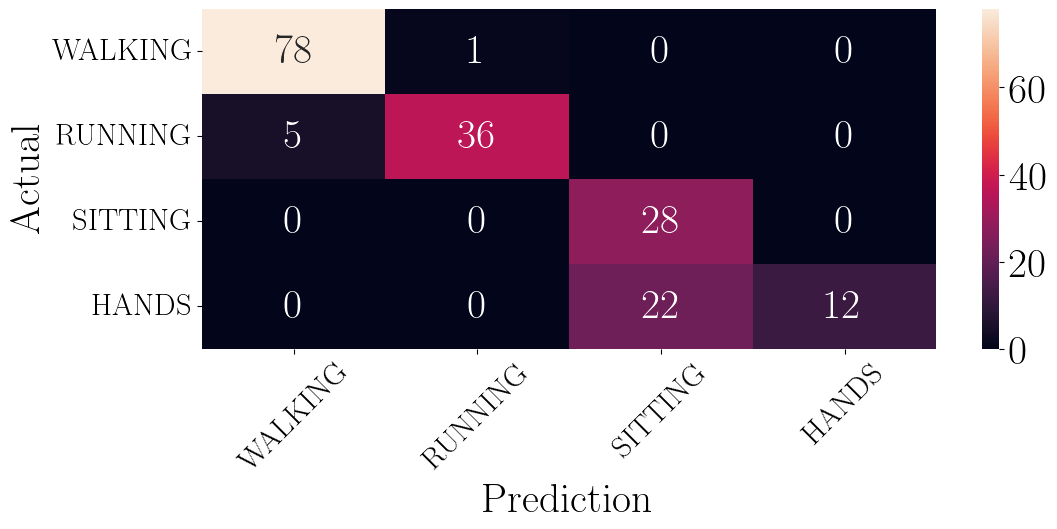

In [36]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_cae2_snn_1.pdf", bbox_inches='tight')
plt.show()

## Encoding capacity

In [ ]:
class LSE_1(nn.Module):
    def __init__(self, autoencoder, classifier):
        super(LSE_1, self).__init__()
        self.autoencoder = autoencoder
        self.classifier = classifier

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.classifier(encoded)  
        return encoded, decoded, clss

In [10]:
path = "./models/model_opt_2.pt"
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE(
  (autoencoder): cae_3(
    (encoder): Sequential(
      (0): Conv3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv3d(128, 2, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (4): BatchNorm3d(12

In [ ]:
path = "./models/model_sae1.pt"
autoencoder = network.sae_lin(
                        input_dim = 64, 
                        surr_grad = params_snn['surrogate_grad'],
                        learn_beta = params_snn['learn_beta'],
                        timesteps = N_WIN
                        ).to(device)

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net_1 = LSE_1(autoencoder, classifier).to(device)
net_1.load_state_dict(torch.load(path))
net_1.eval()

LSE_1(
  (autoencoder): sae_lin(
    (encoder): Linear(in_features=64, out_features=64, bias=True)
    (lif_code): Leaky()
    (decoder): Linear(in_features=64, out_features=64, bias=True)
    (sigmoid): Sigmoid()
  )
  (classifier): snn_1(
    (fc_in): Linear(in_features=1280, out_features=128, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=64, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [54]:
loss_fn = torch.nn.MSELoss()

loss_cae, loss_sae = 0, 0
sparsity_cae, sparsity_sae = [], [] 
shape_prod = 2*232*64*10

with torch.no_grad():
        for X, _, y in test_loader:
            X = X.to(device)

            encoded, decoded, spk_out = net(X.float())
            encoded1, decoded1, spk_out1 = net_1(X.float())

            loss_cae += loss_fn(decoded, X.float())
            loss_sae += loss_fn(decoded1, X.float())

            sparsity_cae.append((1-torch.sum(abs(encoded))/shape_prod).item())

            sparsity_sae.append((1-torch.sum(abs(encoded1))/shape_prod).item())
            
        loss_cae = loss_cae / len(test_loader)
        loss_sae = loss_sae / len(test_loader)

print(f"Reconstruction error of CAE: {round(loss_cae.item(), 4)}")
print(f"Reconstruction error of SAE: {round(loss_sae.item(), 4)}\n")
print(f"Average sparsity of CAE encoding: {round(np.mean(sparsity_cae), 4)}")
print(f"Average sparsity of SAE encoding: {round(np.mean(sparsity_sae), 4)}")

Reconstruction error of CAE: 0.0194
Reconstruction error of SAE: 0.0571

Average sparsity of CAE encoding: 0.7261
Average sparsity of SAE encoding: 0.9678


### Number of trainable parameters and weight of the model

In [ ]:
print(f"# of trainable parameters of CAE: {utils_fn.count_params(net)}")
print(f"# of trainable parameters of SAE: {utils_fn.count_params(net_1)}\n")
print(f"Model size in MB of CAE: {utils_fn.model_size_in_mb(net)} MB")
print(f"Model size in MB of SAE: {utils_fn.model_size_in_mb(net_1)} MB")

# of trainable parameters of CAE: 343380
# of trainable parameters of SAE: 181256

Model size in MB of CAE: 1.31 MB
Model size in MB of SAE: 0.69 MB


## Aircraft marshaling

Compare the encoding with the procedure in this paper

In [47]:
x = next(iter(train_loader))
x[0].shape

torch.Size([8, 2, 232, 10, 64])

In [38]:
def binary_encoding(X):
    """
    X: list of batch tuples
    Returns: tensor of shape (2, 232, 10, 64) with values {-1, 0, 1}
    """
    cir = torch.stack([el[0] for el in X], dim=0) # cir signals
    muD = torch.stack([el[1] for el in X], dim=0)
    Y = torch.stack([el[-1] for el in X], dim=0) # label

    # compute first-order difference along dim=3 (64)
    s_diff = cir[:, :, :, :, 1:] - cir[:, :, :, :, :-1]  # shape (8, 2, 232, 10, 63)

    # repeat the first column to pad and match original shape
    first_col = s_diff[:, :, :, :, 0:1]  # shape (8, 2, 10, 1, 232)
    s = torch.cat([first_col, s_diff], dim=-1)  # shape (8, 2, 232, 10, 64)

    # compute std over dim=3 (64), then mean over dim=2 (10)
    std_over_time = s.std(dim=-1, keepdim=True)  # shape (8, 2, 232, 10, 1)
    alpha = std_over_time.mean(dim=-2, keepdim=True)  # shape (8, 2, 232, 1, 1)

    # thresholding
    output = torch.zeros_like(s)
    output[s > alpha] = 1
    output[s < -alpha] = -1
    
    return (output, muD, Y)

train_loader_enc = DataLoader(
                            train_dataset,
                            batch_size=batch,
                            shuffle=True,
                            num_workers=2,
                            collate_fn=binary_encoding,
                            )

val_loader_enc = DataLoader(
                            val_dataset,
                            batch_size=batch,
                            collate_fn=binary_encoding,
                            )

test_loader_enc = DataLoader(
                            test_dataset,
                            batch_size=1,
                            collate_fn=binary_encoding,
                            )

In [52]:
x = next(iter(val_loader))
x[0].shape

torch.Size([8, 2, 232, 10, 64])

In [53]:
x = next(iter(val_loader_enc))
x[0].shape

torch.Size([8, 2, 232, 10, 64])

### Sparsity of the encoding

In [43]:
sparsity = 0
with torch.no_grad():
        for X, _, y in test_loader:
            X = X.to(device)

            n_spikes, decoded, _ = net(X.float())
            sparsity += 1 - n_spikes

print(f"Sparsity with CAE: {sparsity/len(test_loader):.3f}")
            

Sparsity with CAE: 0.282


In [44]:
path = "./models/scae_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = surrogate.atan()
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

scae = SCAE(autoencoder, snn).to(device)
scae.load_state_dict(checkpoint['model_state_dict'])
scae.eval()

sparsity = 0
with torch.no_grad():
        for X, _, y in test_loader:
            X = X.to(device)

            n_spikes, decoded, _ = scae(X.float())
            sparsity += 1 - n_spikes

print(f"Sparsity with SCAE: {sparsity/len(test_loader):.3f}")

Sparsity with SCAE: 0.804


In [42]:
sparsity1 = 0
with torch.no_grad():
        for X in test_loader_enc:
            X = X[0]
            sparsity1 += 1 - X.abs().mean().item()

avg_sparsity1 =  sparsity1 / len(test_loader_enc)
print(f"Sparsity with binary thresholding: {avg_sparsity1:.3f}")

Sparsity with binary thresholding: 0.717


### Train the snn_1 network with delta thresholded encoded data

In [ ]:
class SNN_CLSFF(nn.Module):
    def __init__(self, snn):
        super(SNN_CLSFF, self).__init__()
        self.snn = snn

    def forward(self, x):
        clss = self.snn(x)  
        n_spikes = x.abs().mean()
        return n_spikes, x, clss

In [ ]:
classifier =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

net = SNN_CLSFF(classifier).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                alpha = 0.95,
                Lambda = 1.0,
                acc_steps = 1,
                patience = 15,
                model_path = "./models/delta_snn_1.pt" 
        )

trainer.fit(
                train_loader = train_loader_enc,
                val_loader = val_loader_enc,
                epochs = 50
        )

Epoch 1 - train_loss: 1.0826 | train_acc: 0.6940 | val_loss: 1.6658 | val_acc: 0.5972
Epoch 6 - train_loss: 0.3261 | train_acc: 0.9917 | val_loss: 1.6725 | val_acc: 0.6389
Epoch 11 - train_loss: 0.2949 | train_acc: 0.9994 | val_loss: 1.9218 | val_acc: 0.6736
Epoch 16 - train_loss: 0.2939 | train_acc: 0.9994 | val_loss: 2.0699 | val_acc: 0.6458
Early stopping at epoch 19


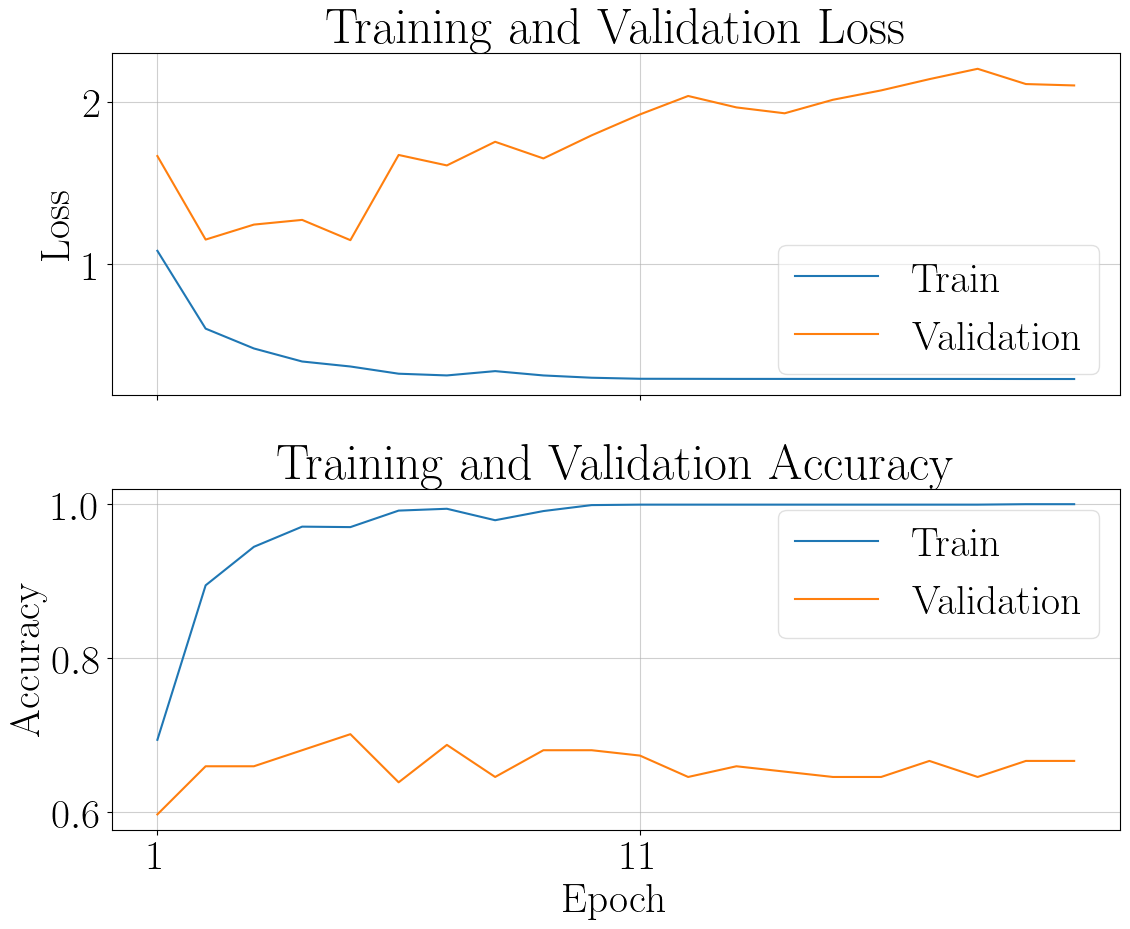

In [63]:
utils_fn.plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

### Results on test set of delta encoded + SNN

In [ ]:
path = "./models/delta_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

net = SNN_CLSFF(classifier).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

Delta_clsff(
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=2048, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [66]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader_enc,
                                avg_type="macro",  
                                verbose=True
                            )

AVERAGE TYPE: macro

Accuracy: 0.7527
Precision: 0.7654
Recall: 0.7110              
F1 score: 0.7172

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.81      0.95      0.87        79
     RUNNING       0.48      0.51      0.49        41
     SITTING       0.97      1.00      0.98        28
       HANDS       0.81      0.38      0.52        34

    accuracy                           0.75       182
   macro avg       0.77      0.71      0.72       182
weighted avg       0.76      0.75      0.74       182



In [67]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader_enc,
                                avg_type="weighted",  
                                verbose=True
                            )

AVERAGE TYPE: weighted

Accuracy: 0.7110
Precision: 0.7579
Recall: 0.7527              
F1 score: 0.7381

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.81      0.95      0.87        79
     RUNNING       0.48      0.51      0.49        41
     SITTING       0.97      1.00      0.98        28
       HANDS       0.81      0.38      0.52        34

    accuracy                           0.75       182
   macro avg       0.77      0.71      0.72       182
weighted avg       0.76      0.75      0.74       182



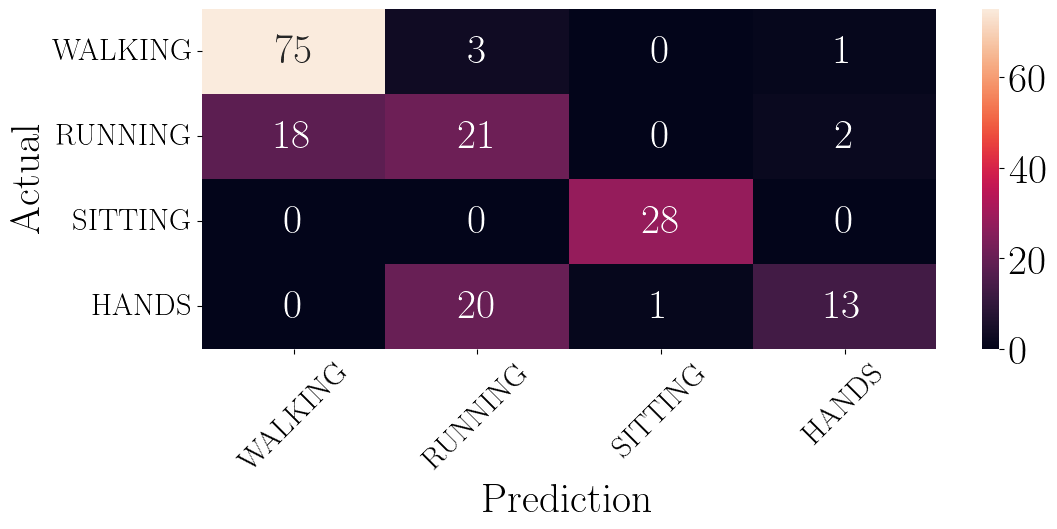

In [68]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_scae_snn_1.png", bbox_inches='tight')
plt.show()

### Classify movements directly from CIR (Direct-SNN)

In [97]:
classifier =  network.snn_conv2(input_shape = INP_SHAPE, 
                                channels = [64, 2],
                                kernel_size=(1,1,3),
                                hidden = [64,128,256], 
                                timesteps = 29,
                                beta = 0.9,
                                threshold = 0.8,
                                learn_thr = True, 
                                learn_beta = True,
                                surr_grad = surrogate.atan()
                                )

net = SNN_CLSFF(classifier).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                Lambda = 0.0,
                acc_steps = 1,
                patience = 15,
                model_path = "./models/direct_snn_conv_1.pt" 
        )

trainer.fit(
                train_loader = train_loader,
                val_loader = val_loader,
                epochs = 50
        )

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


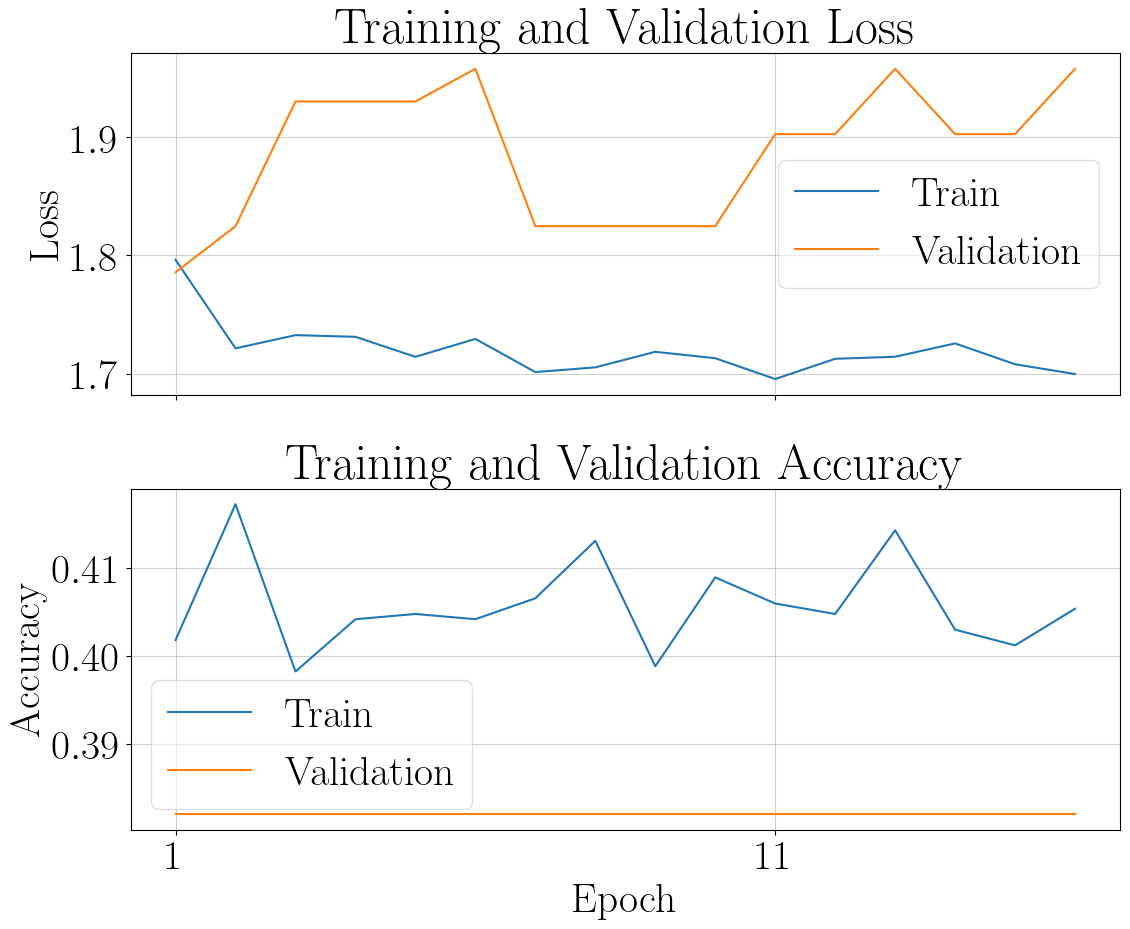

In [91]:
utils_fn.plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

#### Results on test set of Direct-SNN

In [92]:
path = "./models/direct_snn_2.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

net = SNN_CLSFF(classifier).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

RuntimeError: Error(s) in loading state_dict for SNN_CLSFF:
	Missing key(s) in state_dict: "snn.fc_hidden.weight", "snn.fc_hidden.bias", "snn.lif_hidden.threshold", "snn.lif_hidden.beta", "snn.lif_hidden.graded_spikes_factor", "snn.lif_hidden.reset_mechanism_val", "snn.li_out.beta", "snn.li_out.threshold", "snn.li_out.graded_spikes_factor", "snn.li_out.reset_mechanism_val". 
	Unexpected key(s) in state_dict: "snn.fc_hidden1.weight", "snn.fc_hidden1.bias", "snn.lif_hidden1.threshold", "snn.lif_hidden1.beta", "snn.lif_hidden1.graded_spikes_factor", "snn.lif_hidden1.reset_mechanism_val", "snn.fc_hidden2.weight", "snn.fc_hidden2.bias", "snn.lif_hidden2.threshold", "snn.lif_hidden2.beta", "snn.lif_hidden2.graded_spikes_factor", "snn.lif_hidden2.reset_mechanism_val", "snn.lif_out.beta", "snn.lif_out.threshold", "snn.lif_out.graded_spikes_factor", "snn.lif_out.reset_mechanism_val". 
	size mismatch for snn.fc_out.weight: copying a param with shape torch.Size([4, 4096]) from checkpoint, the shape in current model is torch.Size([4, 2048]).

In [94]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                            )

AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.43      1.00      0.61        79
     RUNNING       0.00      0.00      0.00        41
     SITTING       0.00      0.00      0.00        28
       HANDS       0.00      0.00      0.00        34

    accuracy                           0.43       182
   macro avg       0.11      0.25      0.15       182
weighted avg       0.19      0.43      0.26       182



/home/eleonora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eleonora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eleonora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="weighted",  
                                verbose=True
                            )

AVERAGE TYPE: weighted

Accuracy: 0.2500
Precision: 0.1884
Recall: 0.4341              
F1 score: 0.2628

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.43      1.00      0.61        79
     RUNNING       0.00      0.00      0.00        41
     SITTING       0.00      0.00      0.00        28
       HANDS       0.00      0.00      0.00        34

    accuracy                           0.43       182
   macro avg       0.11      0.25      0.15       182
weighted avg       0.19      0.43      0.26       182



/home/eleonora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eleonora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eleonora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


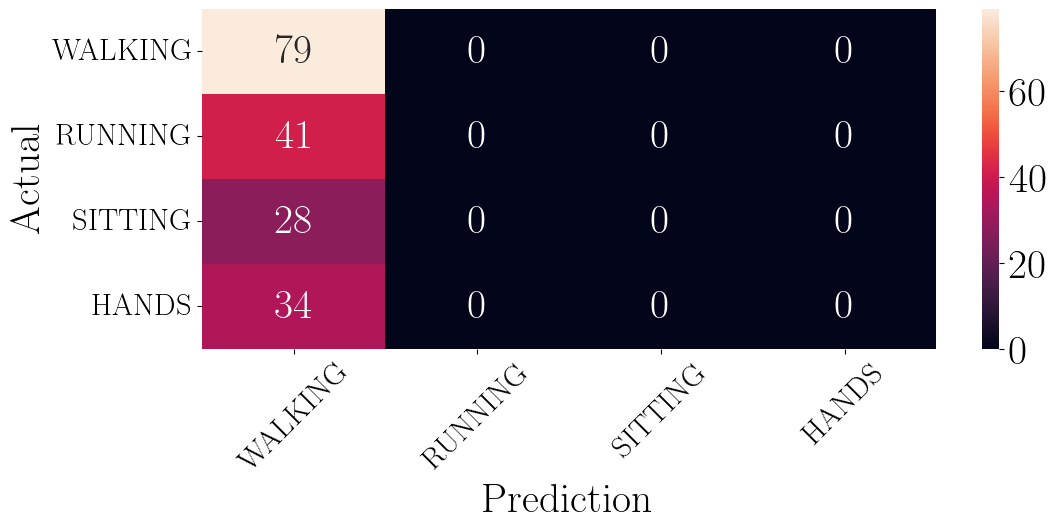

In [96]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_scae_snn_1.png", bbox_inches='tight')
plt.show()

### Train a Direct-SNN with conv layer

### Average number of spikes per neuron

In [4]:
class snn_1(nn.Module):

    def __init__(self, input_dim, hidden, timesteps, n_classes, surr_grad, learn_thr, learn_beta):
        super(snn_1, self).__init__()

        self.input_dim = input_dim        
        self.hidden = hidden
        self.timesteps = timesteps
        self.n_classes = n_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # layer input
        self.fc_in = nn.Linear(in_features=input_dim, out_features=self.hidden[0])
        self.lif_in = snn.Leaky(beta=torch.rand(self.hidden[0]), 
                                threshold=torch.rand(self.hidden[0]),
                                learn_beta=self.learn_beta, learn_threshold=self.learn_thr, 
                                spike_grad=self.surr_grad)

        # layer hidden
        self.fc_hidden = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden = snn.Leaky(beta=torch.rand(self.hidden[1]), 
                                    threshold=torch.rand(self.hidden[1]),
                                    learn_beta=self.learn_beta, learn_threshold=self.learn_thr, 
                                    spike_grad=self.surr_grad)
        
        # layer output
        self.fc_out = nn.Linear(in_features=self.hidden[1], out_features=n_classes)
        self.li_out = snn.Leaky(beta=torch.rand(n_classes), threshold=1.0,
                                #learn_threshold=self.learn_thr, 
                                learn_beta=self.learn_beta,
                                spike_grad=self.surr_grad)

    def forward(self, x):

        mem_in = self.lif_in.init_leaky()
        mem_hid = self.lif_hidden.init_leaky()
        mem_out = self.li_out.init_leaky()
        
        # Record the final layer
        spk_rec = []
        mem_rec = []

        spike_count1 = torch.zeros(self.hidden[0], self.timesteps)
        spike_count2 = torch.zeros(self.hidden[1], self.timesteps)
        spike_count3 = torch.zeros(self.n_classes, self.timesteps)

        for step in range(self.timesteps): # n. timesteps = n. windows

            x_tmstp = torch.reshape(x[:, :, step, :, :], (x.shape[0], -1)) # ~ [batch, 2*10*64]

            cur_in = self.fc_in(x_tmstp) # ~ [batch, 16]
            spk_in, mem_in = self.lif_in(cur_in, mem_in)
            spike_count1[:, step] = spk_in

            cur_hid = self.fc_hidden(spk_in) # ~ [batch, 1]
            spk_hid, mem_hid = self.lif_hidden(cur_hid, mem_hid)
            spike_count2[:, step] = spk_hid

            cur_out = self.fc_out(spk_hid) # ~ [batch, num_classes]
            spk_out, mem_out = self.li_out(cur_out, mem_out)
            spike_count3[:, step] = spk_out

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec, dim=0), spike_count1, spike_count2, spike_count3 #, torch.stack(mem_rec, dim=0)

In [5]:
classifier =  snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    timesteps = N_WIN,
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

path = 'models/model_snn_clss_delta_thr.pt'
classifier.load_state_dict(torch.load(path))
classifier.eval()

snn_1(
  (fc_in): Linear(in_features=1280, out_features=128, bias=True)
  (lif_in): Leaky()
  (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
  (lif_hidden): Leaky()
  (fc_out): Linear(in_features=64, out_features=4, bias=True)
  (li_out): Leaky()
)

In [28]:
tot_spike_count = 0

with torch.no_grad():
        for X, _, y in test_loader_enc:
            X = X.to(device)
        
            spk_out, spike_count1,  spike_count2, spike_count3 = classifier(X.float())

            tot_spike_count += (spike_count1.sum()+spike_count2.sum()+spike_count3.sum())/((128+64+4)*232)

tot_spike_count.item() / len(test_loader_enc)


0.14836201174505825

In [ ]:
spike_count1.mean()

tensor(0.1311)

In [10]:
spike_count2.mean()

tensor(0.1331)

In [3]:
spike_count3.mean()

NameError: name 'spike_count3' is not defined

In [2]:
spike_count1.shape

NameError: name 'spike_count1' is not defined

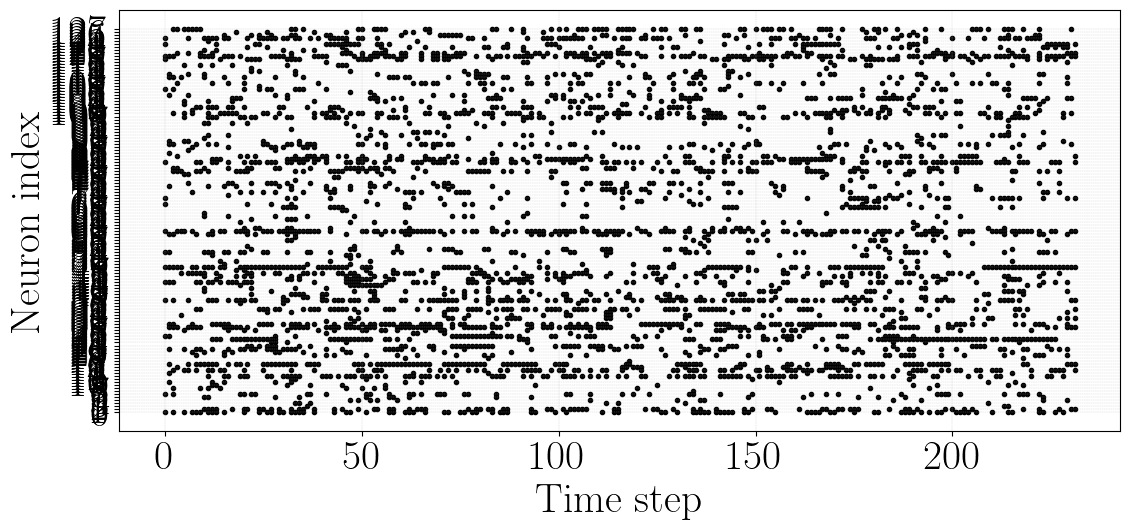

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count1, 0, 1)) # layer input

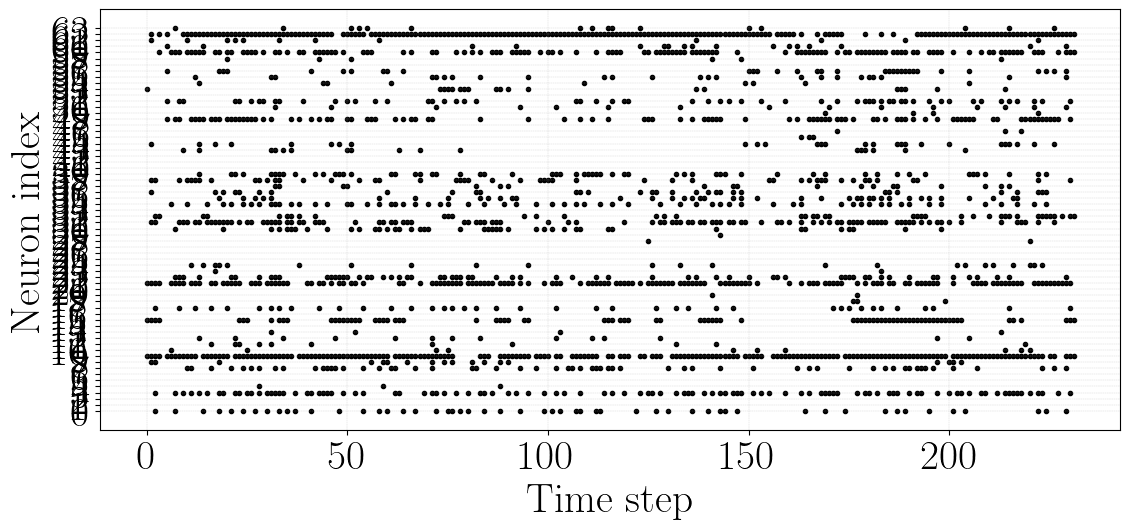

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count2, 0, 1)) # hidden layer

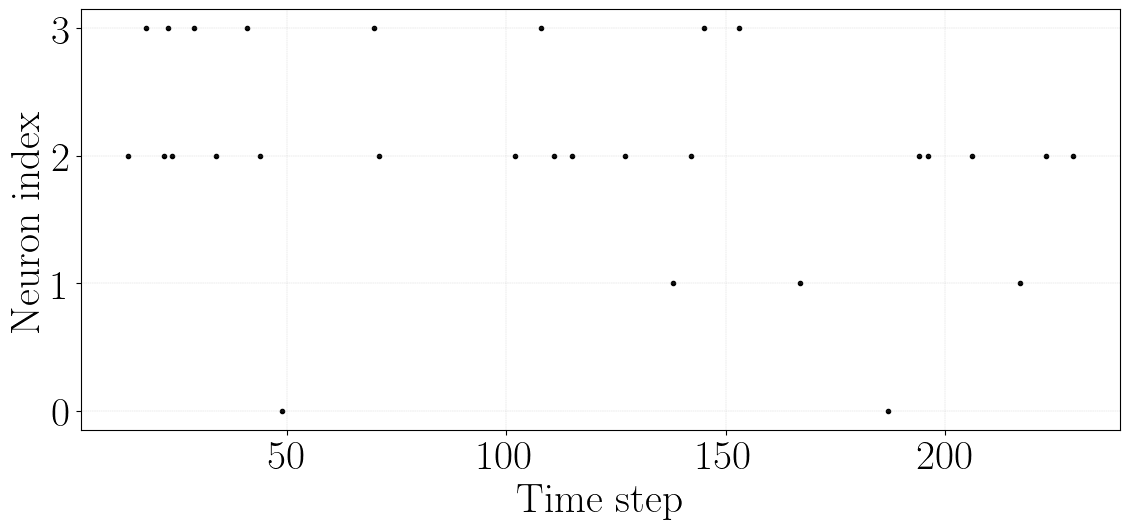

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count3, 0, 1)) # output layer

### nostro approccio

In [20]:
class LSE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(LSE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss, x1, x2, x3 = self.snn(encoded)  
        return encoded, decoded, clss, x1, x2, x3

In [16]:
path = "./models/model_opt_2.pt"
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE(
  (autoencoder): cae_3(
    (encoder): Sequential(
      (0): Conv3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv3d(128, 2, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (4): BatchNorm3d(12

In [26]:
tot_spike_count = 0

with torch.no_grad():
        for X, _, y in test_loader:
            X = X.to(device)
        
            encoded, dec, clss, spike_count1, spike_count2, spike_count3 = net(X.float())

            tot_spike_count += (spike_count1.sum()+spike_count2.sum()+spike_count3.sum())/((128+64+4)*232)

tot_spike_count.item() / len(test_loader)


0.16434373526737608

In [27]:
print(spike_count1.mean())
print(spike_count2.mean())
print(spike_count3.mean())

tensor(0.1617)
tensor(0.2218)
tensor(0.0302)


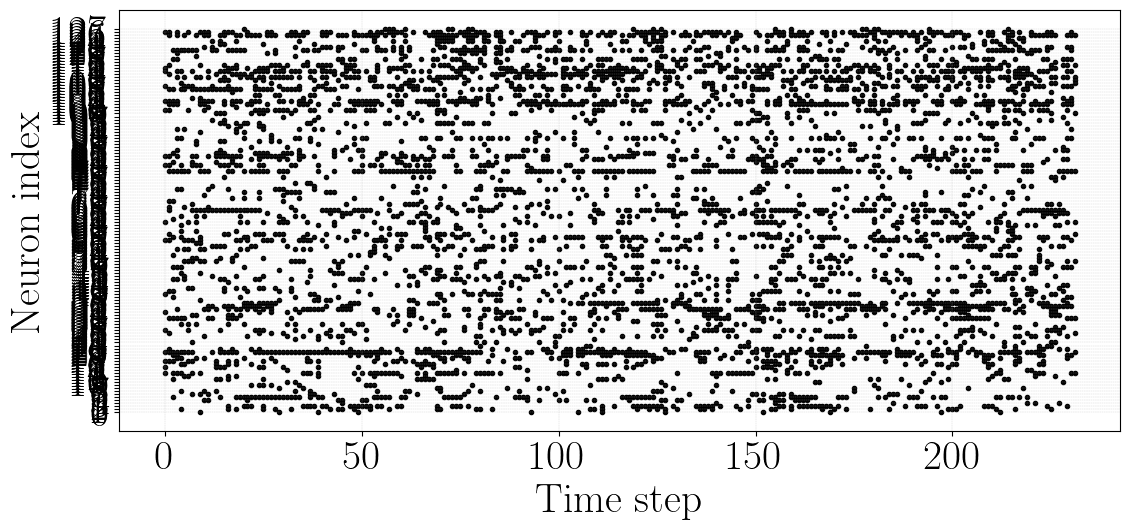

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count1, 0, 1)) # input layer

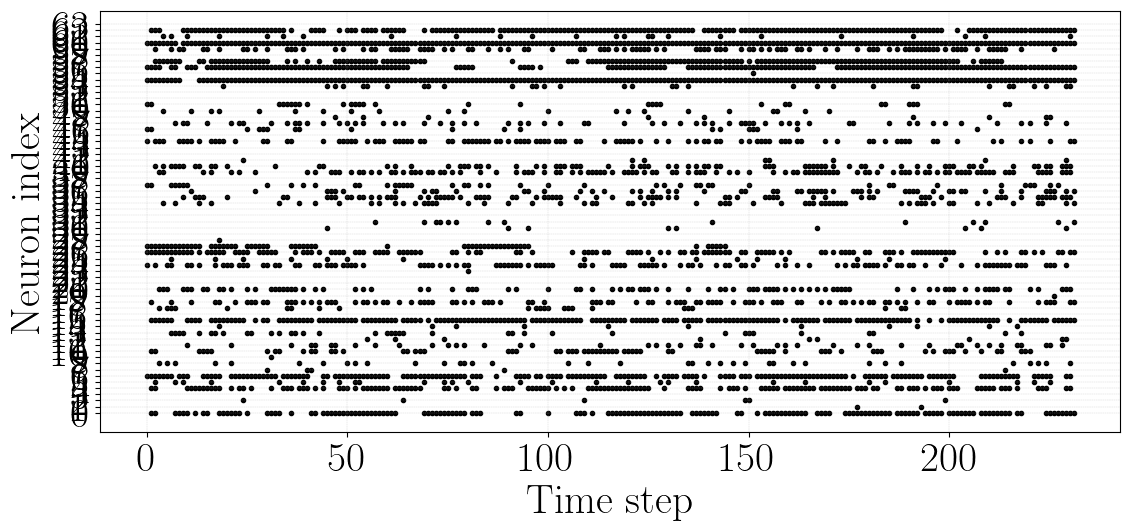

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count2, 0, 1)) # hidden layer

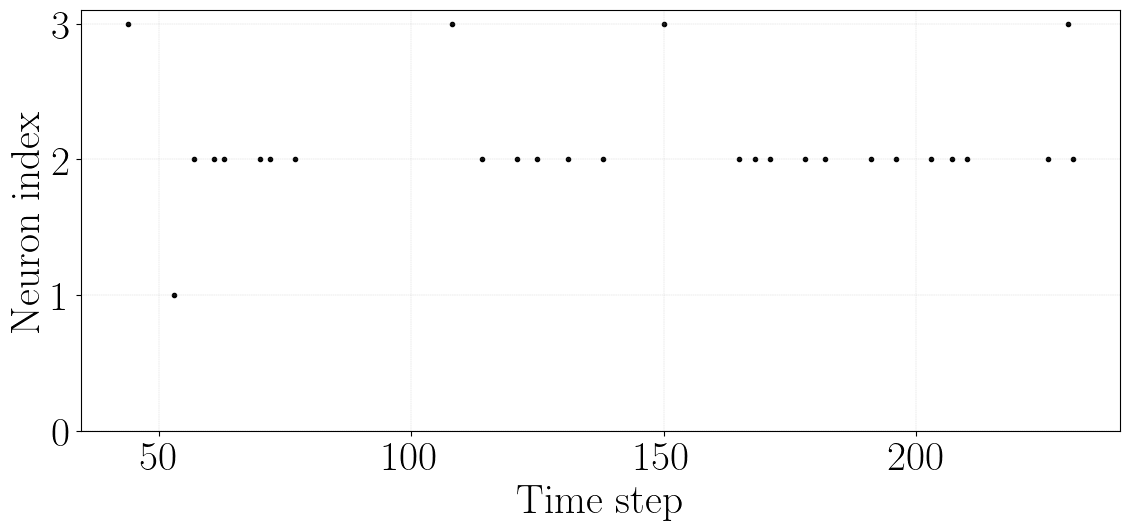

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count3, 0, 1)) # output layer